# MBC, Arrow, PhatGOOSE using microsoft/MTTL

Zero-shot re-use of Parameter-Efficient experts has been tackled in two recent concurrent papers: PhatGOOSE (https://arxiv.org/abs/2402.05859) and Arrow (https://arxiv.org/pdf/2405.11157). In this notebook, we will give a brief overview on how to produce similar results to these papers thanks to the library `https://github.com/microsoft/mttl` which makes it easy to manage and route parameter-efficient experts.

We will also show MBC as a way of clustering experts and re-training experts on similar tasks.

Refer to the papers https://arxiv.org/pdf/2405.11157, https://arxiv.org/abs/2402.05859, or to our survey https://www.arxiv.org/pdf/2408.07057 for more details!

In [ ]:
# let's install MTTL first
!pip install git+https://github.com/microsoft/mttl

# Training Experts

MTTL offers some quick code to train some experts for FLAN and storing them into an "Expert Library". An expert library contains a list of experts and their parameters and that can be stored locally, on HF or on Azure.

The following code trains 10 experts on a subset of data from FLAN (with subsampled examples for each expert) and store them in a local library.

If you don't want to execute the following code, you can alternatively create the local expert library from a pretrained library we provide in `sordonia/trained_gpt125m_experts_colab` (see code below).

In [10]:
# here, we train experts and we upload them to a local library (repository) of experts.

import os
from mttl.arguments import ExpertConfig
from mttl.datamodule.base import get_datamodule
from mttl.models.library.expert_library import ExpertLibrary
from mttl.models.expert_model import ExpertModel, ExpertModelConfig
from mttl.models.train_utils import train_model

# Set this flag to True if you want to re-train the experts!
train_library = False

train_config = ExpertConfig.from_dict(
    {
        "lora_rank": 4,
        "lora_alpha": 1.,
        "lora_dropout": 0.0,
        "weight_decay": 0.0,
        "output_dir": "/tmp/",
        "model_modifier": "lora",
        "modify_modules": ".*",
        "modify_layers": "q_proj|v_proj|k_proj",
        "trainable_param_names": ".*lora_[ab].*",
        "num_train_epochs": 5,
        "learning_rate": 1e-2,
        "micro_batch_size": 16,
        "train_batch_size": 16,
        "predict_batch_size": 8,
        "precision": "bf16",
        "model": "EleutherAI/gpt-neo-125m",
        "model_family": "gpt",
        "optimizer": "adamw",
        "dataset": "sordonia/flan-100-flat",
        "warmup_proportion": 0.,
        "max_input_length": 1024,
        "max_output_length": 128,
        "truncation_side": "left"
    }
)

if train_library:
    library = ExpertLibrary.get_expert_library("local://trained_gpt125m_experts_colab", create=True)

    for task in [
        "wiqa_what_is_the_final_step_of_the_following_process",
        "sciq_Multiple_Choice",
        "adversarial_qa_droberta_answer_the_following_q",
        "duorc_SelfRC_question_answering",
        "cos_e_v1_11_description_question_option_id",
        "race_high_Select_the_best_answer",
        "race_high_Select_the_best_answer_generate_span_",
        "wiki_qa_Is_This_True_",
        "quail_description_context_question_text",
        "wiki_hop_original_explain_relation"
    ]:
        # set the task name to the task we want to finetune on
        train_config.finetune_task_name = task
        # initialize an expert model
        model = ExpertModel(
            ExpertModelConfig(
                base_model=train_config.model,
                expert_name=train_config.finetune_task_name,
                task_name=train_config.finetune_task_name,
                modifier_config=train_config.modifier_config,
            ),
            device_map="cuda",
            precision=train_config.precision,
        )
        # minimal training code to finetune the model on examples from the task
        train_model(train_config, model, get_datamodule(train_config))
        # add the expert to the library!
        expert_instance = model.as_expert(training_config=train_config.to_dict())
        library.add_expert(expert_instance, force=True)
else:
    library = ExpertLibrary.get_expert_library("hf://sordonia/trained_gpt125m_experts_colab").clone("local://trained_gpt125m_experts_colab")


# Let's see which experts are in the library... :-)
for expert_name in library.keys():
    print("Expert: ", expert_name, " with config: ", library[expert_name].expert_config)
print("Experts in library:", len(library))

Expert:  adversarial_qa_droberta_answer_the_following_q  with config:  LoRAConfig(modify_modules='.*', modify_layers='q_proj|v_proj|k_proj', tie_params=None, lora_rank=4, lora_alpha=1.0, lora_dropout=0.0, lora_init_b_random=False)
Expert:  cos_e_v1_11_description_question_option_id  with config:  LoRAConfig(modify_modules='.*', modify_layers='q_proj|v_proj|k_proj', tie_params=None, lora_rank=4, lora_alpha=1.0, lora_dropout=0.0, lora_init_b_random=False)
Expert:  duorc_SelfRC_question_answering  with config:  LoRAConfig(modify_modules='.*', modify_layers='q_proj|v_proj|k_proj', tie_params=None, lora_rank=4, lora_alpha=1.0, lora_dropout=0.0, lora_init_b_random=False)
Expert:  quail_description_context_question_text  with config:  LoRAConfig(modify_modules='.*', modify_layers='q_proj|v_proj|k_proj', tie_params=None, lora_rank=4, lora_alpha=1.0, lora_dropout=0.0, lora_init_b_random=False)
Expert:  race_high_Select_the_best_answer  with config:  LoRAConfig(modify_modules='.*', modify_layers

Ok, this library contains 10 LoRA experts!

# Model-Based Clustering


In our paper, we find that LoRA parameter similarity correlates positively with the transfer between task. So let's run the MBC clustering algorithm on the experts from the library. Procedurally, this clusters LoRA parameters and outputs the expert names in each cluster :-)

In MTTL, any transformation of a library is called `LibraryTransform`. Let's use the `MBCWithCosSimTransform`:

In [ ]:
from mttl.models.library.library_transforms import MBClusteringTransformConfig, MBCWithCosSimTransform

# sparsity threshold, parameters of magnitude less than the threshold are set to 0
# computing cosine similarity between LoRA parameters, this helps reducing noise!
sparsity = 0.2
# number of clusters to produce
k = 2

cfg = MBClusteringTransformConfig(k=k, sparsity_threshold=sparsity)
transform = MBCWithCosSimTransform(cfg)
clusters: dict = transform.transform(library, recompute=True)

# `clusters` is a dict containing task names for each cluster
for cluster in clusters:
    print("Cluster: ", cluster)
    print("Experts: ", clusters[cluster])

with open("mbc_clusters.json", "w") as f:
    import json

    json.dump(clusters, f)

After clustering, we can train join experts on similar tasks. This will increase transfer and reduce interference! To do so, we can use the `train_experts.py` script included in the repository. This will take some time, so feel free to skip this step (we provide another MBC library!)

In [11]:
import copy
from mttl.logging import setup_logging


if train_library:
    train_mbc_config = copy.deepcopy(train_config)

    mbc_library = ExpertLibrary.get_expert_library("local://trained_gpt125m_mbc_experts_colab", create=True)

    for cluster in clusters:
        print("Fine-tuning on cluster: ", cluster, " with tasks: ", clusters[cluster])

        # set the task name to the task we want to finetune on
        train_mbc_config.finetune_task_name = ",".join(clusters[cluster])


        # initialize an expert model
        model = ExpertModel(
            ExpertModelConfig(
                base_model=train_mbc_config.model,
                expert_name=cluster,
                task_name=train_mbc_config.finetune_task_name,
                modifier_config=train_mbc_config.modifier_config,
            ),
            device_map="cuda",
            precision=train_mbc_config.precision,
        )

        # minimal training code to finetune the model on examples from the task
        print(train_mbc_config.finetune_task_name)
        dm = get_datamodule(train_mbc_config)
        print(len(dm.train_dataset) // train_mbc_config.train_batch_size)
        train_model(train_mbc_config, model, dm)

        # add the expert to the library!
        expert_instance = model.as_expert(training_config=train_mbc_config.to_dict())
        mbc_library.add_expert(expert_instance, force=True)
else:
    mbc_library = ExpertLibrary.get_expert_library("hf://sordonia/trained_gpt125m_mbc_experts_colab").clone("local://trained_gpt125m_mbc_experts_colab")

# Let's see which experts are in the library... :-)
for expert_name in mbc_library.keys():
    print("Expert: ", expert_name, " with config: ", mbc_library[expert_name].expert_config)

Expert:  cluster_0  with config:  LoRAConfig(modify_modules='.*', modify_layers='q_proj|v_proj|k_proj', tie_params=None, lora_rank=4, lora_alpha=1.0, lora_dropout=0.0, lora_init_b_random=False)
Expert:  cluster_1  with config:  LoRAConfig(modify_modules='.*', modify_layers='q_proj|v_proj|k_proj', tie_params=None, lora_rank=4, lora_alpha=1.0, lora_dropout=0.0, lora_init_b_random=False)


# In-Distribution Evaluation

Let's evaluate both the private expert and the MBC experts on in-distribution tasks!

We will compare Rouge-L for:

1) oracle routing: use the correct expert for each task \\
2) the average task expert: just average experts for single tasks \\
3) the oracle MBC expert: use the cluster expert trained on each task \\
4) the average MBC expert: average MBC experts then evaluate on all the tasks \\

In [12]:
import torch
import copy
from mttl.arguments import ExpertConfig
from mttl.datamodule.base import get_datamodule
from mttl.models.containers.selectors import TaskNameSelectorConfig, ArrowSelectorConfig
from mttl.models.containers.selectors.base import UniformSelectorConfig
from mttl.models.containers.selectors.poly_selector import PolySelectorDirectConfigUniform
from mttl.models.expert_model import MultiExpertModel, MultiExpertModelConfig
from mttl.evaluators.rouge_evaluator import RougeEvaluator
from mttl.models.library.expert_library import ExpertLibrary


eval_config = copy.deepcopy(train_config)

# let's eval on all the 8 tasks
eval_config.finetune_task_name = ",".join([
    "wiqa_what_is_the_final_step_of_the_following_process",
    "sciq_Multiple_Choice",
    "adversarial_qa_droberta_answer_the_following_q",
    "duorc_SelfRC_question_answering",
    "cos_e_v1_11_description_question_option_id",
    "race_high_Select_the_best_answer",
    "race_high_Select_the_best_answer_generate_span_",
    "wiki_qa_Is_This_True_",
    "quail_description_context_question_text",
    "wiki_hop_original_explain_relation"
])
datamodule = get_datamodule(eval_config, for_generation=True)
evaluator = RougeEvaluator(datamodule)
device_map="cuda" if torch.cuda.is_available() else "cpu"

print("Test examples:", len(datamodule.test_dataset))

# the oracle model uses the "task name" in the forward pass, the task name is passed by the dataloader
model = MultiExpertModel.from_pretrained_library(
    "local://trained_gpt125m_experts_colab",
    selector_config=TaskNameSelectorConfig(),
    device_map=device_map
)
oracle_rouge = evaluator.evaluate(model, split="test")

# now replace selector for lora to a uniform merging of experts during the forward pass
# no task information is used!
model.set_selector("lora", UniformSelectorConfig())
# save model + selector for future re-use
model.save_pretrained("./trained_gpt125m_uniform_model")
uniform_rouge = evaluator.evaluate(model, split="test")

# Now let's test MBC experts that leverage certain multi-task training
# the oracle
model = MultiExpertModel.from_pretrained_library(
    "local://trained_gpt125m_mbc_experts_colab",
    selector_config=TaskNameSelectorConfig(),
    device_map=device_map
)
oracle_mbc_rouge = evaluator.evaluate(model, split="test")

model.set_selector("lora", UniformSelectorConfig())
uniform_mbc_rouge = evaluator.evaluate(model, split="test")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test examples: 80


Adding experts...:   0%|          | 0/10 [00:00<?, ?expert/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Adding experts...:   0%|          | 0/2 [00:00<?, ?expert/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

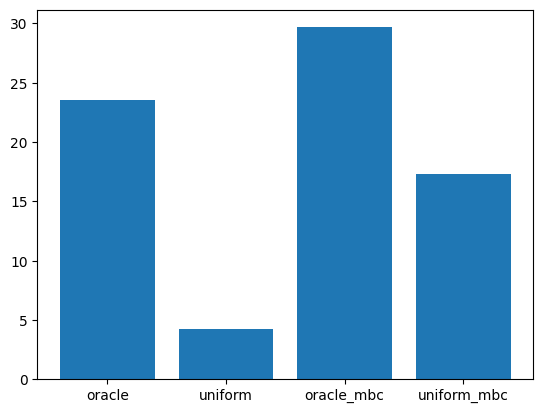

In [13]:
# Let's do some plot

import matplotlib.pyplot as plt

plt.bar(["oracle", "uniform", "oracle_mbc", "uniform_mbc"], [oracle_rouge, uniform_rouge, oracle_mbc_rouge, uniform_mbc_rouge])
plt.show()

Ok we can see that MBC outperforms uniform and also merge better (under uniform merging), let's now compute Arrow!

# Arrow Routing

Arrow selects experts that have "something to say" about a given input: we will select experts that most align with every input hidden representations. With MTTL, Arrow can be computed with the ArrowTransform applied to a library of experts as follows:


In [ ]:
from mttl.models.library.library_transforms import ArrowTransformConfig, ArrowTransform
from mttl.models.containers.selectors import ArrowSelectorConfig

arrow_transform_config = ArrowTransformConfig()
arrow_transform = ArrowTransform(arrow_transform_config)

# persist the prototypes in the library using arrow_transform_config.name
arrow_transform.transform("local://trained_gpt125m_experts_colab", persist=True)

# we inform the selector that we have to read the prototypes corresponding to our config
arrow_selector_config = ArrowSelectorConfig(top_k=2, selector_data_id=arrow_transform_config.save_name)

model = MultiExpertModel.from_pretrained_library(
    "local://trained_gpt125m_experts_colab",
    selector_config=arrow_selector_config,
    device_map="cuda"
)
# save arrowed model for later!
model.save_pretrained("./trained_gpt125m_arrow_model")
arrow_rouge = evaluator.evaluate(model, split="test")

# do the same for MBC library
arrow_transform.transform("local://trained_gpt125m_mbc_experts_colab", persist=True)
# we inform the selector that we have to read the prototypes corresponding to our config
arrow_selector_config = ArrowSelectorConfig(top_k=2, selector_data_id=arrow_transform_config.save_name)
model = MultiExpertModel.from_pretrained_library(
    "local://trained_gpt125m_mbc_experts_colab",
    selector_config=arrow_selector_config,
    device_map="cuda"
)
arrow_mbc_rouge = evaluator.evaluate(model, split="test")

Adding experts...:   0%|          | 0/10 [00:00<?, ?expert/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Adding experts...:   0%|          | 0/2 [00:00<?, ?expert/s]

  0%|          | 0/10 [00:00<?, ?it/s]

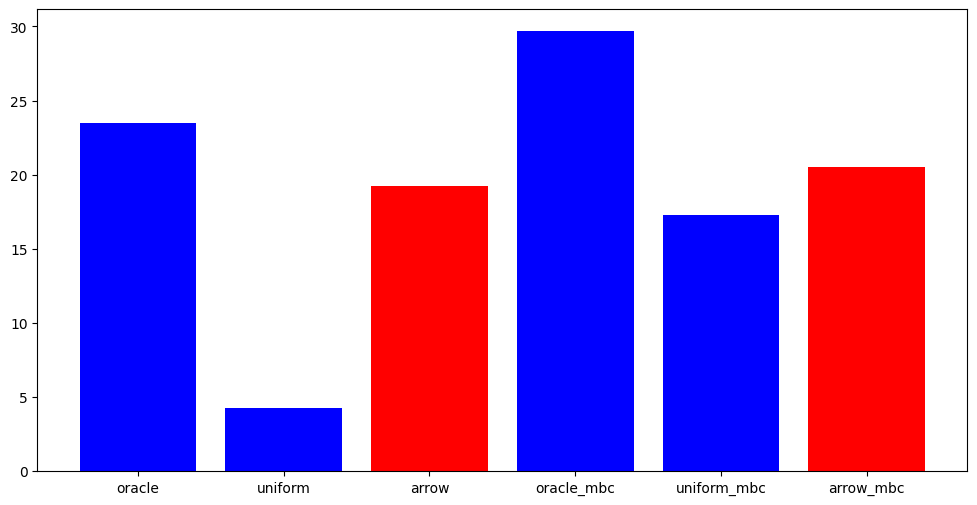

In [18]:
# Let's redo some plots

import matplotlib.pyplot as plt

x_values = ["oracle", "uniform", "arrow", "oracle_mbc", "uniform_mbc", "arrow_mbc"]
y_values = [
    oracle_rouge, uniform_rouge, arrow_rouge,
    oracle_mbc_rouge, uniform_mbc_rouge, arrow_mbc_rouge
]
colors = ["blue", "blue", "red", "blue", "blue", "red"]

plt.figure(figsize=(12, 6))
plt.bar(x_values, y_values, color=colors)
plt.show()

We can see that Arrow greatly fills the gap w.r.t. oracle routing for the private library; conversely for the MBC library it seems to suffer a bit w.r.t. a standard uniform merging of the experts.. Too much interference in the prototypes?

# PhatGOOSE Routing

In [17]:
# Comuting PhatGoose embeddings will take some time as PhatGOOSE requires a few gradient steps for each expert to train the prototypes
# there will be one optimization per expert, so 10 optimizations in total

from mttl.models.library.library_transforms import PhatgooseTransformConfig, PhatgooseTransform
from mttl.models.containers.selectors import PhatgooseSelectorConfig

pg_config = PhatgooseTransformConfig(n_steps=50, learning_rate=1e-3, warmup_ratio=0.0)
pg_transform = PhatgooseTransform(pg_config)

pg_transform.transform("local://trained_gpt125m_experts_colab", persist=True)

# persist the prototypes in the library using pg_config.save_name
pg_selector_config = PhatgooseSelectorConfig(top_k=2, selector_data_id=pg_config.save_name)

model = MultiExpertModel.from_pretrained_library(
    "local://trained_gpt125m_experts_colab",
    selector_config=pg_selector_config,
    device_map="cuda"
)
# save pg model for later!
model.save_pretrained("./trained_gpt125m_pg_model")
pg_rouge = evaluator.evaluate(model, split="test")

pg_transform.transform("local://trained_gpt125m_mbc_experts_colab", persist=True)

# we inform the selector that we have to read the prototypes corresponding to our config
model = MultiExpertModel.from_pretrained_library(
    "local://trained_gpt125m_mbc_experts_colab",
    selector_config=pg_selector_config,
    device_map="cuda"
)
pg_mbc_rouge = evaluator.evaluate(model, split="test")

  0%|          | 0/50 [00:00<?, ?it/s]

Filtering task names (num_proc=16):   0%|          | 0/26400 [00:00<?, ? examples/s]

Creating train set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Creating valid set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Creating test set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Filtering task names (num_proc=16):   0%|          | 0/26400 [00:00<?, ? examples/s]

Creating train set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Creating valid set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Creating test set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Filtering task names (num_proc=16):   0%|          | 0/26400 [00:00<?, ? examples/s]

Creating train set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Creating valid set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Creating test set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Filtering task names (num_proc=16):   0%|          | 0/26400 [00:00<?, ? examples/s]

Creating train set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Creating valid set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Creating test set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Filtering task names (num_proc=16):   0%|          | 0/26400 [00:00<?, ? examples/s]

Creating train set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Creating valid set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Creating test set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Filtering task names (num_proc=16):   0%|          | 0/26400 [00:00<?, ? examples/s]

Creating train set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Creating valid set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

Creating test set (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Adding experts...:   0%|          | 0/10 [00:00<?, ?expert/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Filtering task names (num_proc=16):   0%|          | 0/26400 [00:00<?, ? examples/s]

Creating train set (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Creating valid set (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Creating test set (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Filtering task names (num_proc=16):   0%|          | 0/26400 [00:00<?, ? examples/s]

Creating train set (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Creating valid set (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

Creating test set (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Adding experts...:   0%|          | 0/2 [00:00<?, ?expert/s]

  0%|          | 0/10 [00:00<?, ?it/s]

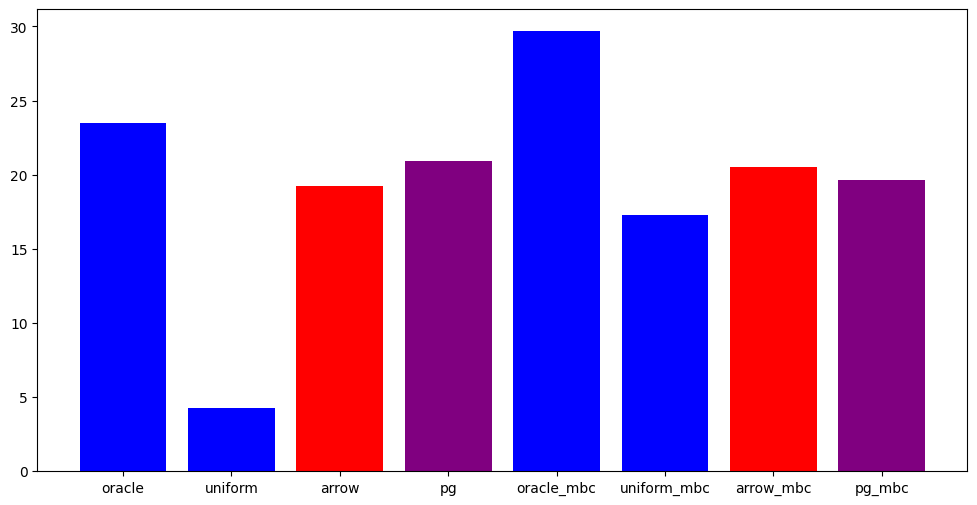

In [19]:
# Let's redo some plots

import matplotlib.pyplot as plt

x_values = ["oracle", "uniform", "arrow", "pg", "oracle_mbc", "uniform_mbc", "arrow_mbc", "pg_mbc"]
y_values = [
    oracle_rouge, uniform_rouge, arrow_rouge, pg_rouge,
    oracle_mbc_rouge, uniform_mbc_rouge, arrow_mbc_rouge, pg_mbc_rouge
]
colors = ["blue", "blue", "red", "purple", "blue", "blue", "red", "purple"]

plt.figure(figsize=(12, 6))
plt.bar(x_values, y_values, color=colors)
plt.show()

# Downstream Evaluation

We will now evaluate both the uniform merged model and the Arrow model on some downstream tasks, e.g. Arc-Easy.

In [20]:
# let's try some out-of-distribution evaluation now!
from mttl.evaluators.base import EvaluatorRunner, setup_evaluators

# we will
evaluation_task = "arc-easy"

with torch.no_grad():
    runner: EvaluatorRunner = setup_evaluators(
        model_type=train_config.model,
        model_family=train_config.model_family,
        max_input_length=train_config.max_input_length,
        max_output_length=train_config.max_output_length,
        predict_batch_size=train_config.predict_batch_size,
        truncation_side=train_config.truncation_side,
        tasks=evaluation_task
    )


# base model
model = MultiExpertModel(MultiExpertModelConfig(base_model="EleutherAI/gpt-neo-125m"), device_map="cuda", precision="32")
base_perf = runner.run(model)

# uniform average of private library
model = MultiExpertModel.from_pretrained("./trained_gpt125m_uniform_model", device_map="cuda", precision="32")
uniform_perf = runner.run(model)

# arrowed private model
model = MultiExpertModel.from_pretrained("./trained_gpt125m_arrow_model", device_map="cuda", precision="32")
arrow_perf = runner.run(model)

# pg private model
model = MultiExpertModel.from_pretrained("./trained_gpt125m_pg_model", device_map="cuda", precision="32")
pg_perf = runner.run(model)

README.md:   0%|          | 0.00/9.00k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/331k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/346k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/86.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2251 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2376 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/570 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/2251 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/2376 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/570 [00:00<?, ? examples/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

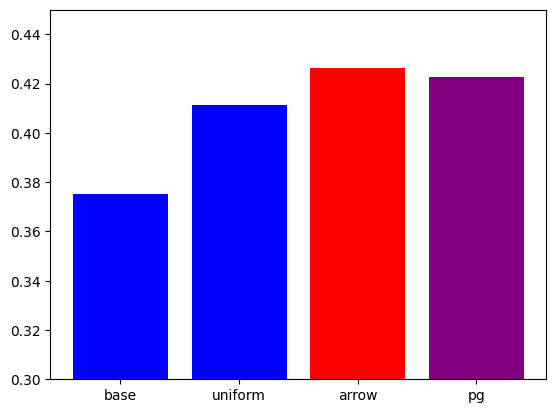

In [21]:
x_values = ["base", "uniform", "arrow", "pg"]
y_values = [
    base_perf['mean'], uniform_perf['mean'], arrow_perf['mean'], pg_perf['mean']
]
colors = ["blue", "blue", "red", "purple"]

plt.figure()
plt.bar(x_values, y_values, color=colors)
plt.ylim([0.3,0.45])
plt.show()